# Машинное обучение, ФКН ВШЭ

# Практическое задание 7

## Общая информация

Дата выдачи: 11.05.2017

Срок сдачи: 23:59MSK 28.05.2017

### О задании

Практическое задание 7 посвящено задаче построения рекомендаций и различным подходам к её решению. В рамках данного задания вы:
 * опробуете различные подходы к построению рекомендаций в задаче рекомендаций фильмов;
 * оцените качество работы различных подходов на различных группах пользователей, изучите наличие известных недостатков рекомендательных систем;
 * познакомитесь со способами оценивания качества работы полученных рекомендательных систем, изучите их достоинства и недостатки.
 
### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW7_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW7_IvanovII.ipynb*). Далее отправьте этот файл на hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+141@gmail.com для студентов группы БПМИ-141).

## Рекомендательные системы

В этой лабораторной работе будет рассмотрена задача предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Мы будем работать с датасетом [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

На основании этих данных необходимо построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

## Оценивание качества рекомендаций

Будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.

Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.

Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (0.5 балла)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен. Отметим, что в этом случае для валидационной и тестовой матриц в каждой строке должно быть ровно 5 ненулевых значений. Рассматривайте только тех пользователей, которые поставили оценки $\ge 11$ фильмам.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные об оценках фильмов пользователями

In [5]:
ratings = pd.read_csv('movielens_data/user_ratedmovies-timestamps.dat', sep='\t')
ratings.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


Так как ID пользователей и ID фильмов в нашем датасете идут не подряд, изменим их, чтобы разреженные матрицы были поменьше (каждый userID заменим на его место в отсортированном списке всех наших userID, то же самое сделаем с movieID).

In [6]:
new_userIDs = {}
userIDs = list(set(ratings['userID']))
userIDs.sort()
for i in range(len(userIDs)):
    new_userIDs[userIDs[i]] = i

new_movieIDs = {}
movieIDs = list(set(ratings['movieID']))
movieIDs.sort()
for i in range(len(movieIDs)):
    new_movieIDs[movieIDs[i]] = i
ratings['compressed_userID'] = [new_userIDs[x] for x in ratings['userID']]
ratings['compressed_movieID'] = [new_movieIDs[x] for x in ratings['movieID']]

Сгруппируем наш датасет по пользователям, используя DataFrame.groupby, и определим оценки, идущие в обучающую, валидационную и тестовую выборки.

In [7]:
train_df = pd.DataFrame(columns=ratings.columns)
val_df = pd.DataFrame(columns=ratings.columns)
test_df = pd.DataFrame(columns=ratings.columns)
grouped = list(ratings.groupby('compressed_userID'))
for item in grouped:
    df = item[1]
    if df.shape[0] < 11:
        continue
    df = df.sort_values(by='timestamp')
    to_test = df[-5:]
    to_val = df[-10:-5]
    to_train = df[:-10]
    train_df = train_df.append(to_train)
    test_df = test_df.append(to_test)
    val_df = val_df.append(to_val)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(834468, 6)
(10565, 6)
(10565, 6)


Наконец, сформируем разреженные матрицы для обучающей, тестовой и валидационной выборок.

In [8]:
from scipy import sparse

In [9]:
n_users = len(new_userIDs)
n_movies = len(new_movieIDs)

In [10]:
train_sm = sparse.csr_matrix((train_df['rating'].values, \
                            (train_df['compressed_userID'].values,\
                             train_df['compressed_movieID'].values)),\
                            shape=(n_users, n_movies))
test_sm = sparse.csr_matrix((test_df['rating'].values, \
                            (test_df['compressed_userID'].values,\
                             test_df['compressed_movieID'].values)),\
                            shape=(n_users, n_movies))
val_sm = sparse.csr_matrix((val_df['rating'].values, \
                            (val_df['compressed_userID'].values,\
                             val_df['compressed_movieID'].values)),\
                            shape=(n_users, n_movies))

Для измерения качества рекомендаций в этом задании будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k вычисляется следующим образом:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Для оценки качества рекомендаций также можно использовать метрику качества ранжирования. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка.

Как и ранее, отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Напомним, что

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

В рамках данного практического задания положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (1 балл)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [11]:
def rmse_score(y_true, y_predicted, k=5):
    if type(y_predicted) == type(sparse.csr_matrix([])):
        y_predicted = y_predicted.toarray()
    else:
        y_predicted = np.array(y_predicted)
    if type(y_true) == type(sparse.csr_matrix([])):
        y_true = y_true.toarray()
    else:
        y_true = np.array(y_true)
    sum_rmses = 0
    n = y_true.shape[0]
    diff_sqrs = (y_predicted - y_true) ** 2
    argsort = y_predicted.argsort(axis=1)[:, ::-1]
    for i in range(n):
        most_recommended = argsort[i][:k]
        sum_rmses += np.sqrt(diff_sqrs[i][most_recommended].mean())
    return sum_rmses / n

def ndcg_score(y_true, y_predicted, k=5):
    if type(y_predicted) == type(sparse.csr_matrix([])):
        y_predicted = y_predicted.toarray()
    else:
        y_predicted = np.array(y_predicted)
    if type(y_true) == type(sparse.csr_matrix([])):
        y_true = y_true.toarray()
    else:
        y_true = np.array(y_true)
    g = lambda r: 2 ** r - 1
    d = lambda i: 1 / np.log2(i + 2)
    max_dcg = g(5) * d(np.arange(k)).sum()
    if type(y_predicted) == type(sparse.csr_matrix([])):
        y_predicted = y_predicted.toarray()
    if type(y_true) == type(sparse.csr_matrix([])):
        y_true = y_true.toarray()
    n, m = y_true.shape
    dcg = []
    argsort = y_predicted.argsort(axis=1)[:, ::-1]
    for i in range(n):
        most_recommended = argsort[i][:k]
        true_ratings = y_true[i][most_recommended]
        dcg.append(np.sum(g(true_ratings) * d(np.arange(k))))
    dcg = np.array(dcg)
    return (dcg / max_dcg).mean()

**3. (0.5 балла)** Разделите индексы пользователей в матрицах из п.1 на 3 группы:
1. пользователи, оценившие менее 20 фильмов;
2. 50 случайных пользователей, оценивших фильмы, имеющие не более 5 оценок;
3. все остальные пользователи.

In [12]:
less_20_rates = [x[0] for x in grouped if x[1].shape[0] < 20]
print(len(less_20_rates))

0


Первая группа пуста - каждый пользователь оценил хотя бы 20 фильмов.

Отберем вторую группу. Для этого посмотрим, сколько раз был оценен каждый фильм.

In [13]:
import collections

In [14]:
all_ratings_sm = sparse.csr_matrix((ratings['rating'], (ratings['compressed_userID'], ratings['compressed_movieID'])))
ratings_by_movies = all_ratings_sm.nonzero()[1]
counter = collections.Counter(ratings_by_movies)
rarely_rated = [i for i in range(n_movies) if counter[i] <= 5]
print('Из {} фильмов {} имеют не более 5 оценок'.format(n_movies, len(rarely_rated)))

Из 10109 фильмов 2248 имеют не более 5 оценок


In [15]:
our_users = set()
for movie in rarely_rated:
    for user in all_ratings_sm.getcol(movie).tocsc().indices:
        our_users.add(user)
print('Всего {} пользователей, оценивших непопулярные фильмы'.format(len(our_users)))

Всего 916 пользователей, оценивших непопулярные фильмы


In [16]:
import random
group2 = set(random.sample(our_users, 50))
group3 = set(range(n_users)) - group2

Для каждой группы сделаем отдельные матрицы.

In [17]:
group2_train_sm = train_sm[list(group2)]
group2_test_sm = test_sm[list(group2)]
group2_val_sm = val_sm[list(group2)]
group3_train_sm = train_sm[list(group3)]
group3_test_sm = test_sm[list(group3)]
group3_val_sm = val_sm[list(group3)]

**4. (0.5 балла)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [18]:
nonzero = train_sm.nonzero()
ones = sparse.csr_matrix((np.ones_like(nonzero[0]), nonzero), shape=(n_users, n_movies))
avg_rating = train_sm.sum(axis=0) / ones.sum(axis=0)
avg_rating = np.array(np.nan_to_num(avg_rating))[0]

/home/ubuntu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [19]:
most_popular_prediction = np.tile(avg_rating, n_users).reshape((n_users, n_movies))

In [20]:
rmse = rmse_score(test_sm, most_popular_prediction)
ndcg = ndcg_score(test_sm, most_popular_prediction)

In [21]:
print('RMSE:', rmse)
print('NDCG:', ndcg)

RMSE: 4.99816123591
NDCG: 0.0005141536439


Значения метрик низкие. Так как у всех пользователей разные предпочтения, то рекомендация всем пользователям одних и тех же популярных фильмов не даст очень хороших результатов. Нужно как-то учитывать предпочтения пользователей.

**5. (1 балл)** Постройте рекомендации на основе user-based коллаборативной фильтрации (подробно метод описан в [лекции 19](https://github.com/esokolov/ml-course-hse/blob/master/2016-spring/lecture-notes/lecture19-recommender.pdf), в качестве функции сходства используйте корреляцию Пирсона), при этом итоговое предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. Значение параметра $\alpha$ подберите на валидационной выборке.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из группы 3.

Для начала построим матрицу похожестей пользователей $W = (w_{uv})$.

In [22]:
W = np.corrcoef(train_sm.todense())

Для $\alpha$ от 0.1 до 0.5 с шагом 0.05 построим предсказание и посмотрим его RMSE и NDCG на валидации. Выберем то $\alpha$, на котором RMSE больше всего.

In [23]:
def user_based_collaborative_filtering(train_sm, alpha):
    r_mean = train_sm.sum(axis=1) / ones.sum(axis=1)
    r_mean = np.array(r_mean).T[0]
    prediction = []
    for u in range(n_users):
        U = np.array(W[u] > alpha).nonzero()[0]
        w = W[u][U]
        R = train_sm[U, :]
        sum_of_collab = w @ (R.T - r_mean[U]).T
        sum_of_collab = np.array(sum_of_collab)[0]
        our_prediction = r_mean[u] + sum_of_collab / w.sum()
        prediction.append(our_prediction)
    prediction = np.array(prediction)
    return prediction

In [24]:
for alpha in np.arange(0.5, 0.09, -0.05):
    min_rmse = 5
    prediction = user_based_collaborative_filtering(train_sm, alpha)
    rmse = rmse_score(val_sm, prediction)
    ndcg = ndcg_score(val_sm, prediction)
    print('alpha = {}, rmse: {}, ndcg: {}'.format(alpha, rmse, ndcg))
    if rmse < min_rmse:
        min_rmse = rmse
        best_alpha = alpha

alpha = 0.5, rmse: 4.857321826935504, ndcg: 0.0
alpha = 0.45, rmse: 4.753820943564251, ndcg: 0.0
alpha = 0.4, rmse: 4.603877807715933, ndcg: 0.00011485239243834863
alpha = 0.35000000000000003, rmse: 4.43084755511802, ndcg: 0.00047831728707678657
alpha = 0.30000000000000004, rmse: 4.24627189960414, ndcg: 0.0008010516560646881
alpha = 0.25000000000000006, rmse: 4.053993266861639, ndcg: 0.0013310159965524379
alpha = 0.20000000000000007, rmse: 3.8589181675838233, ndcg: 0.002239386690723654
alpha = 0.15000000000000008, rmse: 3.684971502953894, ndcg: 0.003987151757503321
alpha = 0.10000000000000009, rmse: 3.553474386906832, ndcg: 0.00569793709359876


Построим прогноз с best_alpha.

In [25]:
prediction = user_based_collaborative_filtering(train_sm, best_alpha)

**6. (0.5 балла)** Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из групп 1 и 2 (по отдельности) для рекомендаций, построенных в п. 5. Ощутимо ли различие со значениями метрик из п. 5? Как это можно объяснить?

Группа 1 пустая. Посмотрим RMSE и nDCG на группе 2.

In [26]:
prediction_for_group2 = prediction[list(group2)]
rmse = rmse_score(group2_test_sm, prediction_for_group2)
ndcg = ndcg_score(group2_test_sm, prediction_for_group2)
print('RMSE:', rmse)
print('NDCG:', ndcg)

RMSE: 3.47081737266
NDCG: 0.00328219553491


**Ответ:** RMSE почти не изменилось. NDCG стало хуже. Причина, скорее всего, в том, что у пользователей, которые смотрят непопулярные фильмы, очень мало других похожих пользователей, и user-based подход не может на них хорошо работать.

**7. (2 балла)** Постройте рекомендации при помощи модели со скрытыми переменными. Напомним, что в данном методе решается следующая оптимизационная задача:
$$\sum_{(u, i) \in R} (r_{ui} - \bar{r}_u - \bar{r}_i - \langle p_u, q_i\rangle)^2 + \lambda \sum_{u \in U} \| p_u\|^2 + \mu \sum_{i \in I} \| q_i\|^2 \to \min_{p_u, q_i}$$

Реализуйте построение рекомендаций при помощи любого из изученных методов оптимизации для данной задачи (SGD, ALS, HALS), подберите значения параметров регуляризации на валидационной выборке и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения). Также разрешается использовать любые свободно распространяемые библиотеки при условии, что функционал совпадает с приведенным выше и используется один из приведенных методов оптимизации. Обращаем ваше внимание, что в оптимизационной задаче суммирование ведется лишь по известным элементам матрицы $R$.

Будем использовать стохастический градиентный спуск (SGD). Изначально вектора $p_u$ и $q_i$ заполнены случайными значениями. На каждом шаге выбирается случайная пара $(u, i)$ из тех, для которых $r_{ui}$ известно. Вектора $p_u$ и $q_i$ изменяются в сторону антиградиента:
$$p_{uk} \text{ += } \eta(q_{ik}(r_{ui} - \bar{r}_u - \bar{r}_i - \langle p_u, q_i\rangle) - \lambda p_{uk};\ \ \ q_{ik} \text{ += } \eta(p_{uk}(r_{ui} - \bar{r}_u - \bar{r}_i - \langle p_u, q_i\rangle) - \mu q_{ik})$$
Ответом будет матрица $p^T q$, отнормированная так, чтобы ее максимум был 5.

Возьмем для начала следующие параметры оптимизации:
$$\eta = 0.05, \lambda = \mu = 1, d = 20$$

In [27]:
def SGD_prediction(R, n_iter=100000, eta_0=0.05, lmbd=1, mu=1, d=20, verbose=0):
    means_by_user = R.sum(axis=1) / ones.sum(axis=1)
    means_by_movie = R.sum(axis=0) / ones.sum(axis=0)
    means_by_user = np.nan_to_num(means_by_user)
    means_by_movie = np.nan_to_num(means_by_movie)
    means_by_user = np.array(means_by_user).T[0]
    means_by_movie = np.array(means_by_movie)[0]
    nonzero_elements = np.array([R.nonzero()[0], R.nonzero()[1]]).T
    p = np.random.random((n_users, d)) / 2
    q = np.random.random((n_movies, d)) / 2
    tiled_mu = np.tile(means_by_user, n_movies).reshape((n_movies, n_users)).T
    tiled_mm = np.tile(means_by_movie, n_users).reshape((n_users, n_movies))
    R_normed = R - tiled_mu - tiled_mm
    for iteration in range(n_iter):
        eta = eta_0
        j = np.random.randint(nonzero_elements.shape[0])
        u, i = nonzero_elements[j]
        dfunc = (R[u].getcol(i)).toarray()[0][0] - means_by_user[u] - means_by_movie[i] - (p[u] * q[i]).sum()
        dp = dfunc * q[i] - lmbd * p[u]
        dq = dfunc * p[u] - mu * q[i]
        if (dp ** 2).mean() > 100 or (dq ** 2).mean() > 100:
            break
        p[u] += eta * dp
        q[i] += eta * dq
        if verbose > 0 and iteration % verbose == 0:
            pq = p @ q.T
            our_funct = np.sum(np.array(R_normed[R.nonzero()] - pq[R.nonzero()]) ** 2)
            print('iteration {}: without reg: {}, with reg: {}'.format(iteration,\
                                                                       our_funct,\
                                                                        our_funct + lmbd * np.sum(p ** 2) + mu * np.sum(q ** 2)))
        
    result = np.matrix(p) * np.matrix(q.T) + tiled_mu + tiled_mm
    return result * 5 / result.max()

In [28]:
predicion = SGD_prediction(train_sm, lmbd=0.1, mu=0.1)
rmse = rmse_score(train_sm, predicion)
print('RMSE:', rmse)
ndcg = ndcg_score(train_sm, predicion)
print('nDCG:', ndcg)

/home/ubuntu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


RMSE: 3.35481717811
nDCG: 0.001628965783


Значения метрик не хуже, чем у предыдущих методов. Подберем параметры: при d=20 подберем $\lambda, \mu$ на значениях из {0.1, 0.3, 1, 3}

In [29]:
for lmbd in [0.1, 0.3, 1, 3]:
    for mu in [0.1, 0.3, 1, 3]:
        prediction = SGD_prediction(train_sm, lmbd=lmbd, mu=mu)
        rmse = rmse_score(val_sm, prediction)
        ndcg = ndcg_score(val_sm, prediction)
        print('lambda: {}, mu: {}, rmse: {}, ndcg: {}'.format(lmbd, mu, rmse, ndcg))

/home/ubuntu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


lambda: 0.1, mu: 0.1, rmse: 3.210446169378368, ndcg: 0.00012762863820372613
lambda: 0.1, mu: 0.3, rmse: 3.1453304550925294, ndcg: 0.0
lambda: 0.1, mu: 1, rmse: 3.1773158779951864, ndcg: 0.00010410203237854945
lambda: 0.1, mu: 3, rmse: 3.388435276376338, ndcg: 0.0004394495801190866
lambda: 0.3, mu: 0.1, rmse: 3.330887539834732, ndcg: 0.000160511218775966
lambda: 0.3, mu: 0.3, rmse: 3.197852045494145, ndcg: 0.0
lambda: 0.3, mu: 1, rmse: 3.368105290978276, ndcg: 3.0045588181993604e-05
lambda: 0.3, mu: 3, rmse: 3.4364864541507627, ndcg: 0.0003909417854597041
lambda: 1, mu: 0.1, rmse: 3.0915590265338806, ndcg: 0.000858746026018513
lambda: 1, mu: 0.3, rmse: 3.41842541202988, ndcg: 0.000531077367223237
lambda: 1, mu: 1, rmse: 3.295212478171099, ndcg: 0.00010127266928452188
lambda: 1, mu: 3, rmse: 3.4529391661917703, ndcg: 0.00034137220057537494
lambda: 3, mu: 0.1, rmse: 3.060338522492304, ndcg: 0.0015095040905035312
lambda: 3, mu: 0.3, rmse: 2.9923250295901433, ndcg: 0.00045145950331047053
la

По совокупности метрик RMSE и nDCG выбираем $\lambda=3, \mu=0.1$.
Теперь посмотрим на ранг разложения d. Посмотрим значения d от 10 до 100 с шагом 10.

In [30]:
D = np.arange(10, 101, 10)
rmses = []
ndcgs = []
for d in D:
    prediction = SGD_prediction(train_sm, lmbd=3, mu=0.1, d=d)
    rmse = rmse_score(val_sm, prediction)
    ndcg = ndcg_score(val_sm, prediction)
    rmses.append(rmse)
    ndcgs.append(ndcg)
    print('d = {}; rmse: {}, ndcg: {}'.format(d, rmse, ndcg))

/home/ubuntu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


d = 10; rmse: 3.414625158328128, ndcg: 0.001354345049571542
d = 20; rmse: 2.8740273633840587, ndcg: 0.0008349740809190478
d = 30; rmse: 2.724576615370436, ndcg: 0.0008824641000862076
d = 40; rmse: 2.6512914626123885, ndcg: 0.000346790746677034
d = 50; rmse: 2.4088005008481113, ndcg: 0.0008370371170772497
d = 60; rmse: 2.2860816444016296, ndcg: 0.0010640406374282643
d = 70; rmse: 2.0929877490900837, ndcg: 0.0005802194369170077
d = 80; rmse: 2.0803726018439446, ndcg: 0.0007436063202135033
d = 90; rmse: 2.0601118455416985, ndcg: 0.0006381310296267728
d = 100; rmse: 2.0268703069920924, ndcg: 0.000337274748460932


Построим графики RMSE и nDCG в зависмости от d.

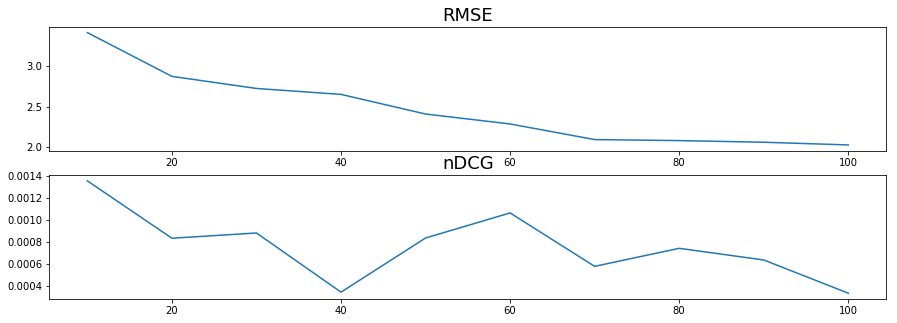

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(2, 1, 1)
plt.title('RMSE', fontsize=18)
plt.plot(D, rmses)
plt.subplot(2, 1, 2)
plt.title('nDCG', fontsize=18)
plt.plot(D, ndcgs)

Выберем d = 60.

**8. (0.5 балла)** Постройте рекомендации с оптимальными значениями гиперпараметров из п. 7 и вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из групп 1, 2 и 3 (по отдельности). Ощутимо ли различие между ними? Как это можно объяснить?

In [32]:
prediction = SGD_prediction(train_sm, lmbd=3, mu=0.1, d=60)

/home/ubuntu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [33]:
rmse_group2 = rmse_score(group2_test_sm, prediction[list(group2)])
ndcg_group2 = ndcg_score(group2_test_sm, prediction[list(group2)])
rmse_group3 = rmse_score(group3_test_sm, prediction[list(group3)])
ndcg_group3 = ndcg_score(group3_test_sm, prediction[list(group3)])
print('group 2:')
print('RMSE: {}, nDCG: {}'.format(rmse_group2, ndcg_group2))
print('group3:')
print('RMSE: {}, nDCG: {}'.format(rmse_group3, ndcg_group3))

group 2:
RMSE: 2.1752352246646636, nDCG: 0.0
group3:
RMSE: 2.3272939282839444, nDCG: 0.000504798593969244


**Ответ:** На второй группе nDCG становится нулем. Это происходит, во-первых, из-за того, что там всего 50 пользователей и у каждого всего 5 оценок на 10000 фильмов - вероятность того, что фильмы, рекомендованные пользователю, им просмотрены и оценены, очень мала, и во-вторых, потому, что фильмы, которые смотрели пользователи из группы 2, непопулярны, и алгоритм не смог нормально на них настроиться. То, что RMSE на первой группе немного меньше, скорее всего, случайность.

**9. (0.5 балла)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения). Постройте рекомендации с оптимальными значениями гиперпараметров  и вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для пользователей из групп 1, 2 и 3 (по отдельности). Как полученные значения отличаются от аналогичных из п. 8? Как это можно объяснить?

In [34]:
from sklearn.decomposition import TruncatedSVD

Построим рекомендации методом TruncatedSVD с рангами разложения от 5 до 50 с шагом 5.

In [35]:
rmses = []
ndcgs = []
for d in range(5, 51, 5):
    svd = TruncatedSVD(n_components=d)
    reduced_matrix = svd.fit_transform(train_sm)
    prediction = reduced_matrix @ svd.components_
    rmse = rmse_score(val_sm, prediction)
    ndcg = ndcg_score(val_sm, prediction)
    rmses.append(rmse)
    ndcgs.append(ndcg)
    print('d: {}, RMSE: {}, nDCG: {}'.format(d, rmse, ndcg))

d: 5, RMSE: 3.1902440661073506, nDCG: 0.00793235976871276
d: 10, RMSE: 3.4238759035832196, nDCG: 0.006637299016805499
d: 15, RMSE: 3.601316440684553, nDCG: 0.006358399744446793
d: 20, RMSE: 3.727934010313734, nDCG: 0.006435105780392679
d: 25, RMSE: 3.826290165888594, nDCG: 0.005202589475959842
d: 30, RMSE: 3.874322680709139, nDCG: 0.004921074031191394
d: 35, RMSE: 3.943977598786668, nDCG: 0.00458986906672127
d: 40, RMSE: 3.996490619460026, nDCG: 0.0046101613082137624
d: 45, RMSE: 4.043141996943926, nDCG: 0.003863361276441369
d: 50, RMSE: 4.072821019303065, nDCG: 0.0034764481768294977


(0, 0.008155155348306924)

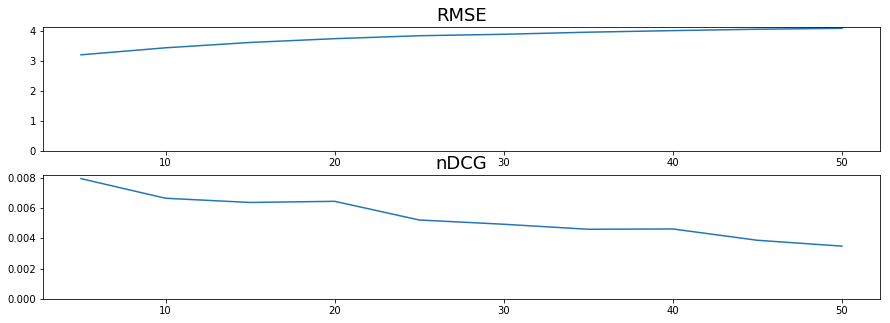

In [37]:
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.title('RMSE', fontsize=18)
plt.plot(range(5, 51, 5), rmses)
plt.ylim((0, None))
plt.subplot(2, 1, 2)
plt.title('nDCG', fontsize=18)
plt.plot(range(5, 51, 5), ndcgs)
plt.ylim((0, None))

С точки зрения обеих метрик, качество предсказания лучше при малых значениях ранга разложения. Возьмем d=5 и посмотрим на значения RMSE и nDCG на 2-й и 3-й группах (первая группа пуста).

In [38]:
d = 5
svd = TruncatedSVD(n_components=d)
reduced_matrix = svd.fit_transform(train_sm)
prediction = reduced_matrix @ svd.components_
rmse_group2 = rmse_score(group2_test_sm, prediction[list(group2)])
ndcg_group2 = ndcg_score(group2_test_sm, prediction[list(group2)])
rmse_group3 = rmse_score(group3_test_sm, prediction[list(group3)])
ndcg_group3 = ndcg_score(group3_test_sm, prediction[list(group3)])
print('group 2:')
print('RMSE: {}, nDCG: {}'.format(rmse_group2, ndcg_group2))
print('group 3:')
print('RMSE: {}, nDCG: {}'.format(rmse_group3, ndcg_group3))

group 2:
RMSE: 4.21301692688006, nDCG: 0.0014135646758971594
group 3:
RMSE: 3.1515393131197067, nDCG: 0.005719751805846875


**Ответ:** на группе 2 значения обеих метрик хуже. В группе 2 есть оценки непопулярных фильмов, которые вносят незначительный вклад в общий функционал, минимизируемый алгоритмом, поэтому SVD для пользователей, оценивших непопулярные фильмы, предсказывает плохо.

**10. (0.5 балла)** Сформируйте обучающие, валидационные и тестовые матрицы объект-признак для следующих наборов признаков:
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование);
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование) + средняя оценка пользователя;
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование) + жанры фильма;
 * id пользователя (бинарное кодирование) + id фильма (бинарное кодирование) + жанры фильма + киноперсоны.

In [39]:
actors_data = pd.read_csv('movielens_data/movie_actors.dat', sep='\t', encoding="ISO-8859-1")
genres_data = pd.read_csv('movielens_data/movie_genres.dat', sep='\t')

Заведем массив жанров и массив актеров для каждого фильма. Каждому жанру и каждому актеру присвоим свой уникальный номер.

In [40]:
all_genres = list(set(genres_data.genre))
number_of_genre = {}
for i in range(len(all_genres)):
    number_of_genre[all_genres[i]] = i
genres = [[] for i in range(n_movies)]
for i in range(genres_data.shape[0]):
    movieID = genres_data.movieID[i]
    genre = genres_data.genre[i]
    if movieID in new_movieIDs:
        genres[new_movieIDs[movieID]].append(number_of_genre[genre])

In [41]:
all_actors = list(set(actors_data.actorID))
number_of_actor = {}
for i in range(len(all_actors)):
    number_of_actor[all_actors[i]] = i
actors = [[] for i in range(n_movies)]
for i in range(actors_data.shape[0]):
    movieID = actors_data.movieID[i]
    actor_name = actors_data.actorID[i]
    if movieID in new_movieIDs:
        actors[new_movieIDs[movieID]].append(number_of_actor[actor_name])

Введем несколько функций, кодирующих признаки в sparse matrix.

In [42]:
def encode_user_and_movie_ids(R):
    R_coo = R.tocoo()
    n_rates = R_coo.data.shape[0]
    data = np.ones(2 * n_rates)
    rows = np.hstack((np.arange(n_rates), np.arange(n_rates)))
    cols = np.hstack((R_coo.row, R_coo.col + n_users))
    return sparse.csr_matrix((data, (rows, cols)), shape=(n_rates, n_users + n_movies))

def encode_user_means(R):
    means = np.array(R.mean(axis=0))[0]
    R_coo = R.tocoo()
    n_rates = R_coo.data.shape[0]
    users = R_coo.row
    data = means[users]
    rows = np.arange(n_rates)
    cols = np.zeros_like(rows)
    return sparse.csr_matrix((data, (rows, cols)), shape=(n_rates, 1))

def encode_movie_genres(R):
    R_coo = R.tocoo()
    n_rates = R_coo.data.shape[0]
    cols = []
    rows = []
    for i in range(n_rates):
        movie = R_coo.col[i]
        n_genres = len(genres[movie])
        rows += [i] * n_genres
        cols += genres[movie]
    data = np.ones_like(np.array(cols))
    return sparse.csr_matrix((data, (rows, cols)), shape=(n_rates, len(all_genres)))

def encode_movie_actors(R):
    R_coo = R.tocoo()
    n_rates = R_coo.data.shape[0]
    cols = []
    rows = []
    for i in range(n_rates):
        movie = R_coo.col[i]
        rows += [i] * len(actors[movie])
        cols += actors[movie]
    data = np.ones_like(np.array(cols))
    return sparse.csr_matrix((data, (rows, cols)), shape=(n_rates, len(all_actors)))

In [43]:
train_userid_movieid = encode_user_and_movie_ids(train_sm)
val_userid_movieid = encode_user_and_movie_ids(val_sm)
test_userid_movieid = encode_user_and_movie_ids(test_sm)

train_uid_mid_mean = sparse.hstack((encode_user_and_movie_ids(train_sm), encode_user_means(train_sm)))
val_uid_mid_mean = sparse.hstack((encode_user_and_movie_ids(val_sm), encode_user_means(val_sm)))
test_uid_mid_mean = sparse.hstack((encode_user_and_movie_ids(test_sm), encode_user_means(test_sm)))

train_uid_mid_genres = sparse.hstack((encode_user_and_movie_ids(train_sm), encode_movie_genres(train_sm)))
val_uid_mid_genres = sparse.hstack((encode_user_and_movie_ids(val_sm), encode_movie_genres(val_sm)))
test_uid_mid_genres = sparse.hstack((encode_user_and_movie_ids(test_sm), encode_movie_genres(test_sm)))

train_uid_mid_actors = sparse.hstack((encode_user_and_movie_ids(train_sm), encode_movie_actors(train_sm)))
val_uid_mid_actors = sparse.hstack((encode_user_and_movie_ids(val_sm), encode_movie_actors(val_sm)))
test_uid_mid_actors = sparse.hstack((encode_user_and_movie_ids(test_sm), encode_movie_actors(test_sm)))

Запишем также вектор целевой переменной - столбцы оценок для обучающей, тестовой и валидационной выборок.

In [44]:
y_train = train_sm.data
y_val = val_sm.data
y_test = test_sm.data

**11. (1.5 балла)** Для каждой из выборок из предыдущего пункта постройте рекомендации при помощи факторизационных машин из библиотеки [LibFM](http://libfm.org) с использованием метода оптимизации ALS, подобрав оптимальную размерность разложения на валидационной выборке. Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке для оптимальных значений гиперпараметров. Какой набор признаков оказался самым удачным? Как это можно объяснить?
При выполнении данного задания вам также может пригодиться библиотека [pywFM](https://github.com/jfloff/pywFM), являющаяся python-обёрткой над LibFM.

In [45]:
import pywFM

Заведем функцию choose_optimal_d, которая принимает на вход обучающую и валидационную выборки, а также соответствующие вектора целевых переменных и выдает ту размерность из множества {2, 5, 10, 20, 50, 100}, на которой получается лучший результат на валидационной выборке. Также заведем функцию run_on_test_sample, которая обучает факторизационную машину с рангом разложения d на обучающей выборке и дает результаты ее предсказания на тестовой выборке.

In [84]:
def choose_optimal_d(X_train, X_val, Y_train, Y_val, val_sm):
    best_score = 0
    best_d = 0
    D = [2, 5, 10, 20, 50, 100]
    for d in D:
        machine = pywFM.FM(task='regression', learning_method='als', k2=d)
        run = machine.run(X_train, Y_train, X_val, Y_val)
        prediction_matrix = sparse.csr_matrix(val_sm)
        prediction_matrix.data = np.array(run.predictions)
        rmse = rmse_score(val_sm, prediction_matrix)
        ndcg = ndcg_score(val_sm, prediction_matrix)
        print('d =', d)
        print('RMSE:', rmse)
        print('nDCG:', ndcg)
        score = 2 - rmse + 2 * ndcg
        if score > best_score:
            best_score = score
            best_prediction = prediction_matrix
            best_d = d
            best_rmse = rmse
            best_ndcg = ndcg
    return best_d

In [77]:
def run_on_test_sample(X_train, X_test, y_train, y_test, test_sm, d):
    machine = pywFM.FM(task='regression', learning_method='als', k2=d)
    run = machine.run(X_train, y_train, X_test, y_test)
    prediction_matrix = sparse.csr_matrix(test_sm)
    prediction_matrix.data = np.array(run.predictions)
    rmse = rmse_score(test_sm, prediction_matrix)
    ndcg = ndcg_score(test_sm, prediction_matrix)
    print('RMSE on test sample:', rmse)
    print('nDCG on test sample:', ndcg)

Теперь посмотрим, как работает факторизационная машина на признаках userID 

In [86]:
%%time
optimal_d = choose_optimal_d(train_userid_movieid,\
                                                              val_userid_movieid,\
                                                              y_train,\
                                                              y_val,\
                                                              val_sm)
print('optimal decomposition rank:', optimal_d)
run_on_test_sample(train_userid_movieid, test_userid_movieid, y_train, y_test, test_sm, optimal_d)

d = 2
RMSE: 0.760095419986
nDCG: 0.45967753957
d = 5
RMSE: 0.800083453861
nDCG: 0.459271274486
d = 10
RMSE: 0.89103884302
nDCG: 0.456817704495
d = 20
RMSE: 1.02491824679
nDCG: 0.453367101962
d = 50
RMSE: 1.24026822643
nDCG: 0.449863089345
d = 100
RMSE: 1.37010320226
nDCG: 0.446287397325
optimal decomposition rank: 2
RMSE on test sample: 0.787335358839
nDCG on test sample: 0.460840283922
CPU times: user 1min 12s, sys: 2.31 s, total: 1min 14s
Wall time: 8min 52s


Запустим факторизационную машину на наборе признаков (id пользователя, id фильма, средняя оценка пользователя).

In [87]:
%%time
optimal_d = choose_optimal_d(train_uid_mid_mean,\
                                                              val_uid_mid_mean,\
                                                              y_train,\
                                                              y_val,\
                                                              val_sm)
print('optimal decomposition rank:', optimal_d)
run_on_test_sample(train_uid_mid_mean, test_uid_mid_mean, y_train, y_test, test_sm, optimal_d)

d = 2
RMSE: 0.76744483538
nDCG: 0.459857070878
d = 5
RMSE: 0.798304306888
nDCG: 0.459804664988
d = 10
RMSE: 0.891535553331
nDCG: 0.457126178261
d = 20
RMSE: 1.0295142792
nDCG: 0.453230140301
d = 50
RMSE: 1.22845428693
nDCG: 0.449823961195
d = 100
RMSE: 1.35995684915
nDCG: 0.448520515281
optimal decomposition rank: 2
RMSE on test sample: 0.794082560343
nDCG on test sample: 0.461214525373
CPU times: user 1min 33s, sys: 2.77 s, total: 1min 36s
Wall time: 12min 24s


И на наборе признаков (id пользоавтеля, id фильма, жанры фильма):

In [ ]:
%%time
optimal_d = choose_optimal_d(train_uid_mid_genres,\
                                                              val_uid_mid_genres,\
                                                              y_train,\
                                                              y_val,\
                                                              val_sm)
print('optimal decomposition rank:', optimal_d)
run_on_test_sample(train_uid_mid_genres, test_uid_mid_genres, y_train, y_test, test_sm, optimal_d)

d = 2
RMSE: 0.760421744948
nDCG: 0.45962474852
d = 5
RMSE: 0.795236410647
nDCG: 0.459088144119
d = 10
RMSE: 0.876394152318
nDCG: 0.457881179212
d = 20
RMSE: 0.993584672848
nDCG: 0.455058741934
d = 50
RMSE: 1.19959851174
nDCG: 0.450083226533
d = 100
RMSE: 1.31926468083
nDCG: 0.447531530266
optimal decomposition rank: 2
RMSE on test sample: 0.785131294866
nDCG on test sample: 0.460402664133
CPU times: user 1min 53s, sys: 2.74 s, total: 1min 56s
Wall time: 21min 15s


И, наконец, на наборе (id пользователя, id фильма, актеры):

In [ ]:
%%time
optimal_d = choose_optimal_d(train_uid_mid_actors,\
                                                              val_uid_mid_actors,\
                                                              y_train,\
                                                              y_val,\
                                                              val_sm)
print('optimal decomposition rank:', optimal_d)
run_on_test_sample(train_uid_mid_actors, test_uid_mid_actors, y_train, y_test, test_sm, optimal_d)

d = 2
RMSE: 0.757756452369
nDCG: 0.459402717323
d = 5
RMSE: 0.797044974923
nDCG: 0.458787467416
d = 10
RMSE: 0.878254159769
nDCG: 0.457091932482
d = 20
RMSE: 1.0028188794
nDCG: 0.453253424279
d = 50
RMSE: 1.20289505443
nDCG: 0.450933070564
d = 100
RMSE: 1.3967536102
nDCG: 0.448268876192
optimal decomposition rank: 2
RMSE on test sample: 0.784400245597
nDCG on test sample: 0.460444142824
CPU times: user 8min 28s, sys: 7.72 s, total: 8min 35s
Wall time: 3h 25min 32s


**Ответ:** На всех выборках значения RMSE и nDCG почти одинаковые. Данные о фильмах почти не добавляют информации с точки зрения модели.

**12. (1 балл)** Приведите сравнение качества всех моделей, руководствуясь значениями описанных метрик. Какие из моделей оказались лучше других по каждой из метрик? Как это можно объяснить?

**Ответ**: По обеим метрикам лучше всего качество у факторизационных машин. Это объясняется тем, что они предсказывают оценки только на тех фильмах, на которых реальные оценки известны. В остальных моделях оценки предсказывались по каждому фильму для всех пользователей, и при вычислении метрик неизвестные оценки считались равными нулю, поэтому значение $r_{u(i)}$ в большинстве слагаемых было нулем, из-за чего значения метрик были гораздо хуже.

Из остальных моделей лучшее значение nDCG@5 показывает разреженный SVD, а лучшее значение RMSE@5 у модели со скрытыми переменными. Первое объясняется тем, что SVD - самый продвинутый из использованных нами методов (модель со скрытыми переменными, по сути, является SVD с рангом разложения 1, а user-based коллаборативная фильтрация учитывает информацию о пользователях, но не учитывает информацию о фильмах). Второе объясняется, скорее всего, тем, что из-за нормировки оценки стали ближе к нулю - самому часто встречающемуся значению в тестовой выборке.